In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/octis_model_results'

Mounted at /content/drive


In [5]:
def load_results(base_path):
    results = {}
    for model_name in os.listdir(base_path):
        model_path = os.path.join(base_path, model_name)
        if os.path.isdir(model_path):
            results_file = os.path.join(model_path, 'result.json')
            if os.path.exists(results_file):
                with open(results_file, 'r') as f:
                    results[model_name] = json.load(f)
    return results


def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] > c, axis=1)
            is_efficient[i] = True
    return is_efficient


def process_results(results):
    processed_data = {}
    for model_name, model_results in results.items():
        coherence_values = model_results['f_val']
        diversity_values = [max(v) for v in model_results['dict_model_runs']['0_TopicDiversity'].values()]

        # Filter out invalid results
        valid_indices = [i for i, (c, d) in enumerate(zip(coherence_values, diversity_values))
                         if c != -1 and d != 0 and d != -1]  # Also exclude 0 diversity

        if not valid_indices:
            print(f"Warning: Model {model_name} has no valid results and will be excluded.")
            continue

        valid_coherence = [coherence_values[i] for i in valid_indices]
        valid_diversity = [diversity_values[i] for i in valid_indices]

        # Calculate Pareto efficiency
        costs = np.column_stack((-np.array(valid_coherence), -np.array(valid_diversity)))
        pareto_efficient = is_pareto_efficient(costs)

        processed_data[model_name] = {
            'iterations': len(valid_indices),
            'best_coherence': max(valid_coherence),
            'best_diversity': max(valid_diversity),
            'params': {k: [v[i] for i in valid_indices] for k, v in model_results['x_iters'].items()},
            'coherence_values': valid_coherence,
            'diversity_values': valid_diversity,
            'pareto_efficient': pareto_efficient
        }
    return processed_data


def analyze_correlations(processed_data):
    correlations = {}
    for model_name, data in processed_data.items():
        params = pd.DataFrame(data['params'])
        coherence = data['coherence_values']
        diversity = data['diversity_values']

        param_correlations = {}
        for param in params.columns:
            coherence_corr, _ = spearmanr(params[param], coherence)
            diversity_corr, _ = spearmanr(params[param], diversity)
            param_correlations[param] = {
                'coherence': coherence_corr,
                'diversity': diversity_corr
            }
        correlations[model_name] = param_correlations
    return correlations


def plot_performance(processed_data):
    plt.figure(figsize=(12, 8))
    for model_name, data in processed_data.items():
        plt.scatter(data['coherence_values'], data['diversity_values'], label=model_name, alpha=0.7)
    plt.xlabel('Coherence')
    plt.ylabel('Diversity')
    plt.title('Model Performance: Coherence vs Diversity')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_param_influence(correlations):
    model_names = list(correlations.keys())
    params = list(correlations[model_names[0]].keys())

    fig, axes = plt.subplots(len(params), 2, figsize=(15, 5*len(params)))
    fig.suptitle('Parameter Influence on Coherence and Diversity')

    for i, param in enumerate(params):
        coherence_corrs = [correlations[model][param]['coherence'] for model in model_names]
        diversity_corrs = [correlations[model][param]['diversity'] for model in model_names]

        axes[i, 0].bar(model_names, coherence_corrs)
        axes[i, 0].set_title(f'{param} - Coherence')
        axes[i, 0].set_xticklabels(model_names, rotation=45, ha='right')

        axes[i, 1].bar(model_names, diversity_corrs)
        axes[i, 1].set_title(f'{param} - Diversity')
        axes[i, 1].set_xticklabels(model_names, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


def plot_pareto_front(processed_data):
    plt.figure(figsize=(12, 8))
    for model_name, data in processed_data.items():
        coherence = data['coherence_values']
        diversity = data['diversity_values']
        pareto = data['pareto_efficient']

        plt.scatter(coherence, diversity, label=f'{model_name} (Non-Pareto)', alpha=0.5)
        plt.scatter(np.array(coherence)[pareto], np.array(diversity)[pareto],
                    label=f'{model_name} (Pareto)', marker='*', s=100)

    plt.xlabel('Coherence')
    plt.ylabel('Diversity')
    plt.title('Pareto Front of Model Performances')
    plt.legend()
    plt.grid(True)
    plt.show()


def find_best_models(processed_data):
    if not processed_data:
        print("No valid models found after filtering.")
        return pd.DataFrame()

    model_performance = {}
    for model_name, data in processed_data.items():
        model_performance[model_name] = {
            'coherence': data['best_coherence'],
            'diversity': data['best_diversity']
        }

    df = pd.DataFrame(model_performance).T
    if df.empty:
        print("No valid data for any models after filtering.")
        return df

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    df_scaled['combined_score'] = df_scaled['coherence'] + df_scaled['diversity']

    return df_scaled.sort_values('combined_score', ascending=False)


Top 5 Best Performing Models:
                                  coherence  diversity  combined_score
paraphrase-mpnet-base-v2           1.000000        0.0        1.000000
multi-qa-mpnet-base-cos-v1         0.827127        0.0        0.827127
paraphrase-distilroberta-base-v1   0.820084        0.0        0.820084
all-MiniLM-L12-v2                  0.457705        0.0        0.457705
paraphrase-MiniLM-L6-v2            0.000000        0.0        0.000000

Best parameters for paraphrase-mpnet-base-v2:
bertopic__min_topic_size: 63
bertopic__top_n_words: 22
hdbscan__min_cluster_size: 500
hdbscan__min_samples: 72
umap__min_dist: 0.07781750274004018
umap__n_components: 9
umap__n_neighbors: 11
vectorizer__min_df: 0.00937194090166088
Best Coherence: 0.46918696453838604
Best Diversity: 1.0
Number of Pareto efficient points: 6

Best parameters for multi-qa-mpnet-base-cos-v1:
bertopic__min_topic_size: 29
bertopic__top_n_words: 14
hdbscan__min_cluster_size: 427
hdbscan__min_samples: 11
umap__min_dis

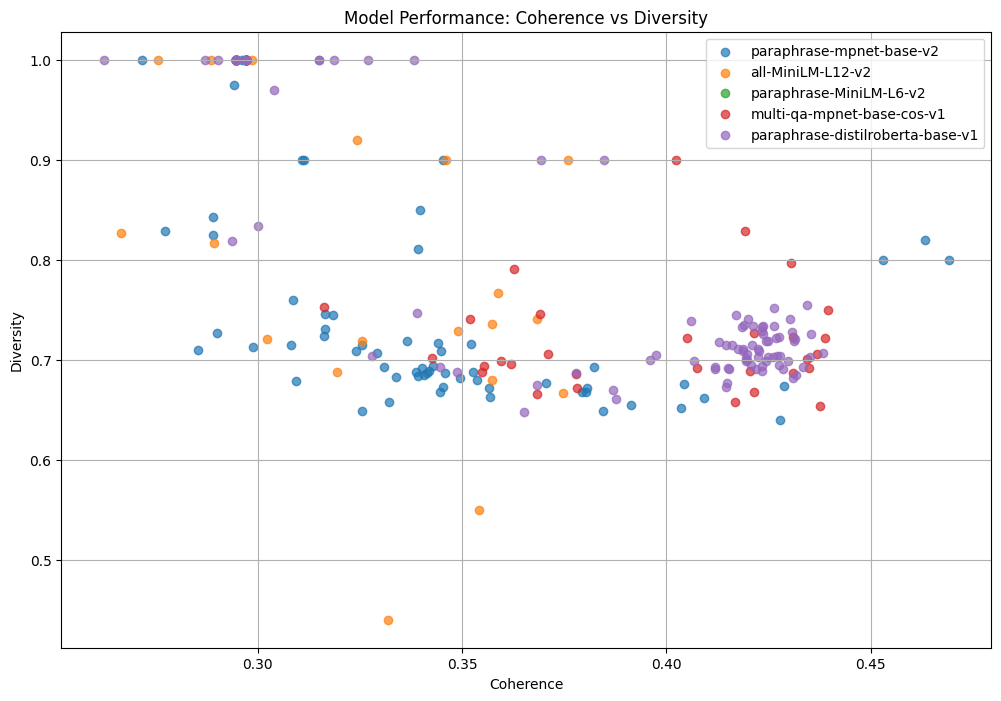

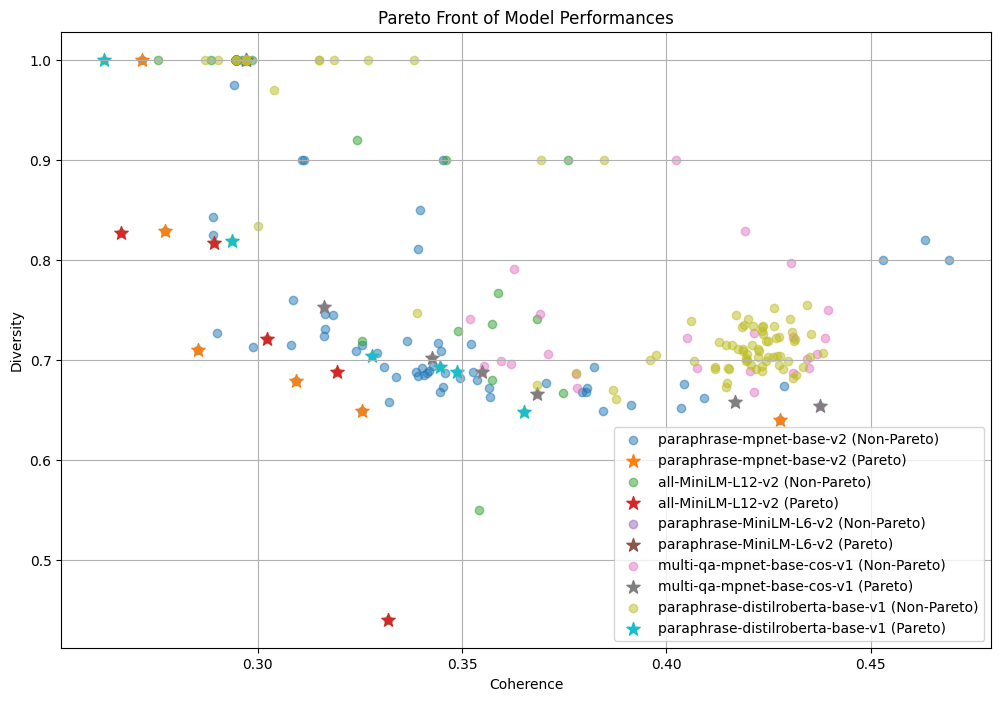

In [6]:
def main():
    results = load_results(base_path)
    processed_data = process_results(results)

    if not processed_data:
        print("No valid models found after filtering. Exiting.")
        return

    best_models = find_best_models(processed_data)
    if best_models.empty:
        print("No valid data for any models after filtering. Exiting.")
        return

    print("Top 5 Best Performing Models:")
    print(best_models.head())

    for model in best_models.head().index:
        print(f"\nBest parameters for {model}:")
        best_iteration = processed_data[model]['coherence_values'].index(processed_data[model]['best_coherence'])
        for param, values in processed_data[model]['params'].items():
            print(f"{param}: {values[best_iteration]}")
        print(f"Best Coherence: {processed_data[model]['best_coherence']}")
        print(f"Best Diversity: {processed_data[model]['best_diversity']}")
        pareto_efficient_count = sum(processed_data[model]['pareto_efficient'])
        print(f"Number of Pareto efficient points: {pareto_efficient_count}")


    # Only proceed with other analyses if we have valid data
    if not best_models.empty:
        correlations = analyze_correlations(processed_data)
        plot_performance(processed_data)
        # plot_param_influence(correlations)
        plot_pareto_front(processed_data)

main()